In [173]:
%matplotlib inline

## Standard imports

In [174]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.linalg as linalg

np.random.seed(31415926)

## Utility functions

In [175]:
def mv_normal(m, C):
    """ Samples a multivariate normal of mean m and covariance C
    Example:
    >>> m = np.array([0., 0.])
    >>> C = np.eye(2)
    >>> mv_normal(m, C).size
    2
    """
    sample = np.random.randn(*m.shape)
    return m + linalg.cholesky(C, lower=True) @ sample

In [176]:
def rmse(x, y):
    """ Root mean square error between two vectors x and y
    Example:
    >>> x = np.ones(10)
    >>> y = np.ones(10) * 0.5
    >>> rmse(x, y)
    0.5
    """
    return np.sqrt(np.mean(np.square(x-y)))

In [177]:
def filter_routine(initial_guess, initial_guess_covariance, update_method, observations):
    """ Loops over the observations and calls the implemented update_method
    Example:
    >>> initial_guess = np.array([0, 0])
    >>> initial_covariance = np.eye(2)
    >>> def update_method(x, cov, obs): return x, cov
    >>> observations = np.random.randn(500)
    >>> states, state_covariances = filter_routine(initial_guess, initial_covariance, update_method, observations)
    >>> shape_ok = states.shape[0] == state_covariances.shape[0] == observations.shape[0]
    >>> values_ok = np.all(states == 0)
    >>> values_ok and shape_ok
    True
    """
    T = observations.shape[0]
    x = initial_guess[:]
    cov = initial_guess_covariance[:]
    
    states = np.empty((T, *x.shape))
    covariances = np.empty((T, *initial_guess_covariance.shape))
    
    for i, y in enumerate(observations):
        x, cov = update_method(x, cov, y)
        states[i, :] = x
        covariances[i, :] = cov
    
    return states, covariances
    

In [178]:
def plot_results(filtered_states, true_states, observations, title, conflev, filtered_covariances=None):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharex=True)
    
    T = observations.shape[0]
    
    axes[0,0].plot(filtered_states[:, 0], label="Estimated signal; component 1", marker="d", color="b")
    axes[0,0].plot(true_states[:, 0], label="True signal; component 1", linestyle='--', marker="*", color="r")
    axes[0,0].scatter(np.arange(T), observations, marker="o", color="g", label="Measurements")    
    
    axes[1,0].plot(filtered_states[:, 1], label="Estimated derivative; component 1", marker="d", color="b")
    axes[1,0].plot(true_states[:, 1], label="True derivative; component 1", linestyle='--', marker="*", color="r")
    
    axes[0,1].plot(filtered_states[:, 2], label="Estimated signal; component 2", marker="d", color="b")
    axes[0,1].plot(true_states[:, 2], label="True signal; component 2", linestyle='--', marker="*", color="r")
    axes[0,1].scatter(np.arange(T), observations, marker="o", color="g", label="Measurements")    
    
    axes[1,1].plot(filtered_states[:, 3], label="Estimated derivative; component 2", marker="d", color="b")
    axes[1,1].plot(true_states[:, 3], label="True derivative; component 2", linestyle='--', marker="*", color="r")
    
    error1 = rmse(filtered_states[:, 0:2], true_states[:, 0:2])
    error2= rmse(filtered_states[:, 2:4], true_states[:, 2:4])
    
    for ax in axes.flatten():
        ax.legend(loc="upper left")
    
    if filtered_covariances is not None:
        axes[0,0].fill_between(np.arange(T), 
                             filtered_states[:, 0] - conflev * np.sqrt(filtered_covariances[:, 0, 0]),
                             filtered_states[:, 0] + conflev * np.sqrt(filtered_covariances[:, 0, 0]),
                             alpha=0.33, 
                             color="b")
        axes[1,0].fill_between(np.arange(T), 
                             filtered_states[:, 1] - conflev * np.sqrt(filtered_covariances[:, 1, 1]),
                             filtered_states[:, 1] + conflev * np.sqrt(filtered_covariances[:, 1, 1]),
                             alpha=0.33, 
                             color="b")
        axes[0,1].fill_between(np.arange(T), 
                             filtered_states[:, 2] - conflev * np.sqrt(filtered_covariances[:, 2, 0]),
                             filtered_states[:, 2] + conflev * np.sqrt(filtered_covariances[:, 2, 0]),
                             alpha=0.33, 
                             color="b")
        axes[1,1].fill_between(np.arange(T), 
                             filtered_states[:, 3] - conflev * np.sqrt(filtered_covariances[:, 3, 1]),
                             filtered_states[:, 3] + conflev * np.sqrt(filtered_covariances[:, 3, 3]),
                             alpha=0.33, 
                             color="b")
        fig.suptitle(f"{title} and confidence intervals - RMSE1: {error1:.3f}, RMSE2: {error2:.3f}")
    else:
        fig.suptitle(f"{title} - RMSE1 = {error1:.3f}, RMSE2 = {error2:.3f}")


## Get data

We generate $T=100$ observations according to the following model: 
\begin{equation}
    x_t = A x_{t-1} + \mathcal{N}(0, Q), \quad y_t = \left(\begin{matrix}1 & 0\end{matrix}\right) x_t + \mathcal{N}(0, r), \quad x_0 = \left(\begin{matrix}0 & 0.1\end{matrix}\right)^T
\end{equation}

where we have $A = \left(\begin{matrix} \cos(\omega) & \frac{\sin(\omega)}{\omega} \\ -\omega \sin(\omega) & \cos(\omega)\end{matrix}\right), \quad 
Q = \frac 1 2 q \left(\begin{matrix}
                \frac{\omega - \cos(\omega) \sin(\omega)}{\omega^3} &
                \frac{\sin(\omega) ^2 }{\omega^2}   
            \\
                \frac{\sin(\omega) ^2 }{\omega^2}  &
                \frac{\omega + \cos(\omega) \sin(\omega)}{\omega} 
        \end{matrix}\right)$


For the remainder of the notebook, we will take: 
- $\omega = 0.5$
- $q = 0.01$
- $r = 0.1$

In [179]:
w = 0.5
q = 0.01
r = 0.1

T = 100
x_0 = np.array([0, 0.1, 0, 0])

In [180]:
def get_data(w, q, r, x_0, T):
    """ Generates data according to the state space model above
    Example:
    >>> observations, true_states, _, _, _ = get_data(0.25, 0.01, 0.1, np.array([0, 0.1]), 50)
    >>> observations.shape[0] == true_states.shape[0] == 50
    True
    """
    Q = 0.5 * q * np.array([[(w - np.cos(w) * np.sin(w)) / w ** 3, np.sin(w) ** 2 / w ** 2],
                            [np.sin(w) ** 2 / w ** 2, (w + np.cos(w) * np.sin(w)) / w]])
    
    Q_2= np.array([list(Q[0])+ [0,0], list(Q[1])+ [0,0], [0,0]+ list(Q[0]), [0,0]+ list(Q[1])])

    A = np.array([[np.cos(w), np.sin(w) / w], 
                  [-w * np.sin(w), np.cos(w)]])
    
    A_2= np.array([list(A[0])+ [0,0], list(A[1])+ [0,0], [0,0]+ list(A[0]), [0,0]+ list(A[1])])
    
    C = np.array([0, 0])
    
    C_2= np.array([1,0,0,0])
    
    observations = np.empty(T)
    true_states = np.empty((T, 4))
    
    x = x_0[:]
    true_states[0] = x
    
    for i in range(T):
        observations[i] = C_2.dot(x) + np.sqrt(r) * np.random.randn()
        x = mv_normal(np.matmul(A_2, x), Q_2)
        if i == T-1:
            break
        true_states[i+1, :] = x
        
    return observations, true_states, Q_2, A_2, C_2


In [181]:
observations, true_states, Q, A, C = get_data(w, q, r, x_0, T)

In [182]:
matrix_0= np.zeros(shape=Q.shape)
list(Q[0])+ [0,0]

[0.00317058030384207, 0.004596976941318603, 0.0, 0.0, 0, 0]

In [183]:
def plot_state(observations, true_states, T):
    fig, ax = plt.subplots(2,1,figsize=(12, 6),sharex='all')
    ax[0].plot(true_states[:, 0], linestyle='--', label="True Signal")
    ax[0].scatter(np.arange(T), observations, marker='o', label="Measurements")
    ax[0].legend(loc="upper left")
    ax[1].plot(true_states[:, 1], linestyle='--', label="True Signal")
    ax[1].set_xlabel("Time step")
    ax[1].legend(loc="upper left")
    fig.suptitle("Simulated data")

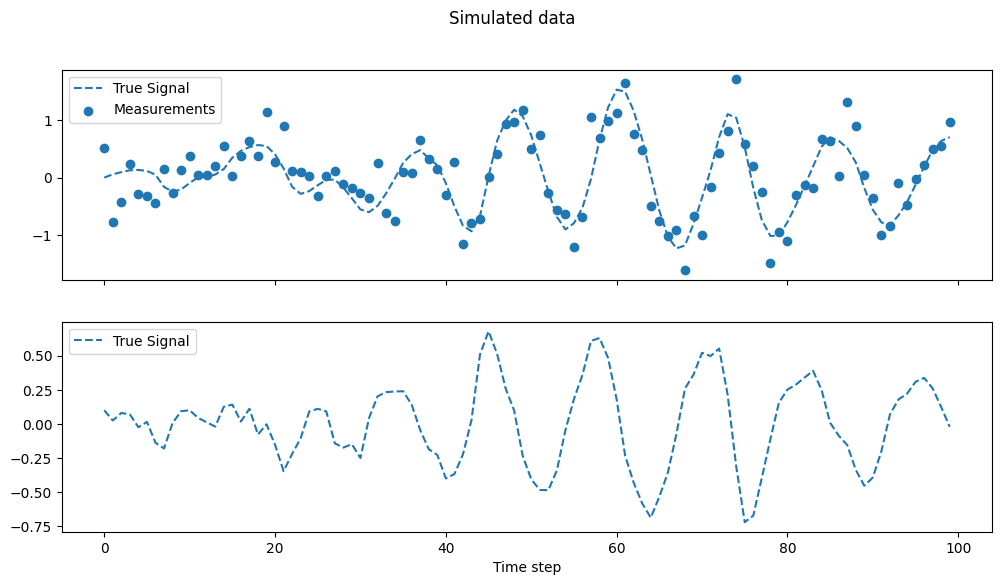

In [184]:
plot_state(observations, true_states, T)

## Initial Guess

We will now consider that our initial guess for the first state is given by $x_0 \sim \mathcal{N}\left(\left(\begin{matrix}0 \\ 1\end{matrix}\right), I_2\right)$

In [185]:
initial_state = np.array([0, 1, 2, 5])
initial_covariance = np.eye(4)

## Kalman Filter

In [186]:
def kf_update_predict(x, cov, obs):
    """ Implements the kalman equations as given in "Simo Särkkä and Lennart Svensson (2023), Bayesian Filtering and Smoothing, 2nd ed. Cambridge University Press", Ch. 6.3
    Uses the global variables A, Q, C, r

    THIS FUNCTION reverses the order: update first and then forecast! how will you use this one??
    """
    # You should replace the below equations
    # x is xfmean = forecast mean
    # cov is pfcov = forecast covariance
    ###### kalmangain =  cov @ C.T @ np.linalg.inv( C @ cov @ C.T + r) 
    kalmangain =  cov @ C.T / ( C @ cov @ C.T + r) 
    # kalman gain (using forecast covariance)
    ###### xamean = x + kalmangain @ (obs - C @ x)  # analysis mean
    xamean = x + kalmangain * (obs - C @ x)  # analysis mean
    ###      pacov =  cov - kalmangain * C @ cov  # analysis covariance
    pacov =  cov - kalmangain @ kalmangain.T * ( C @ cov @ C.T + r)  # analysis covariance
    # 'new_x' will be new xfmean = forecast mean at next time
    # 'new_cov' will be new pfcov = forecast covariance at next time
    new_x = A @ xamean
    new_cov = A @ pacov @ A.T + Q
    return new_x, new_cov

In [187]:
def kf_predict_update(x, cov, obs):
    """ Implements the kalman equations as given in "Simo Särkkä and Lennart Svensson (2023), Bayesian Filtering and Smoothing, 2nd ed. Cambridge University Press", Ch. 6.3
    Uses the global variables A, Q, C, r
    """
    # You should replace the below equations
    #### forecast
    xfmean = A @ x
    pfcov = (A @ cov @ A.T + Q ) * 5
    #### update - but first calculate K = Kalman Gain
    kalmangain =  pfcov @ C.T / ( C @ pfcov @ C.T + r) 
    new_x = xfmean + kalmangain * (obs - C @ xfmean)  # analysis mean
    new_cov = pfcov - kalmangain @ C * pfcov
    return new_x, new_cov

In [188]:
kalman_states, kalman_covariances = filter_routine(initial_state, initial_covariance, kf_predict_update, observations)

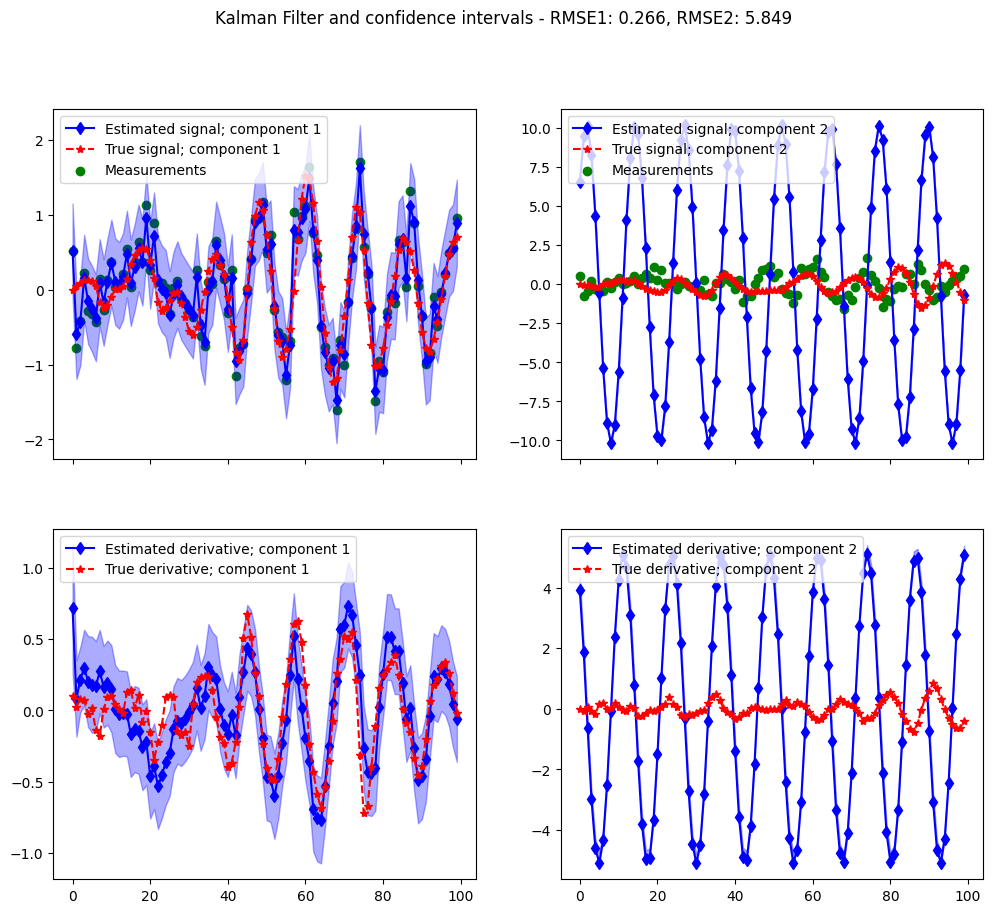

In [189]:
plot_results(kalman_states, true_states, observations, "Kalman Filter", 2.0, kalman_covariances)

Component 1 refers to x[0:2] and component 2 refers to x[2:4], they are the two different noisy uncoupled resonators


### Stability

Choose different initial condition and compare with the previous run

In [190]:
initial_state = np.array([1.5, 2.3, 2, 4])
initial_covariance = kalman_covariances[80] * 5.8

In [191]:
kalman_states1, kalman_covariances1 = filter_routine(initial_state, initial_covariance, kf_predict_update, observations)

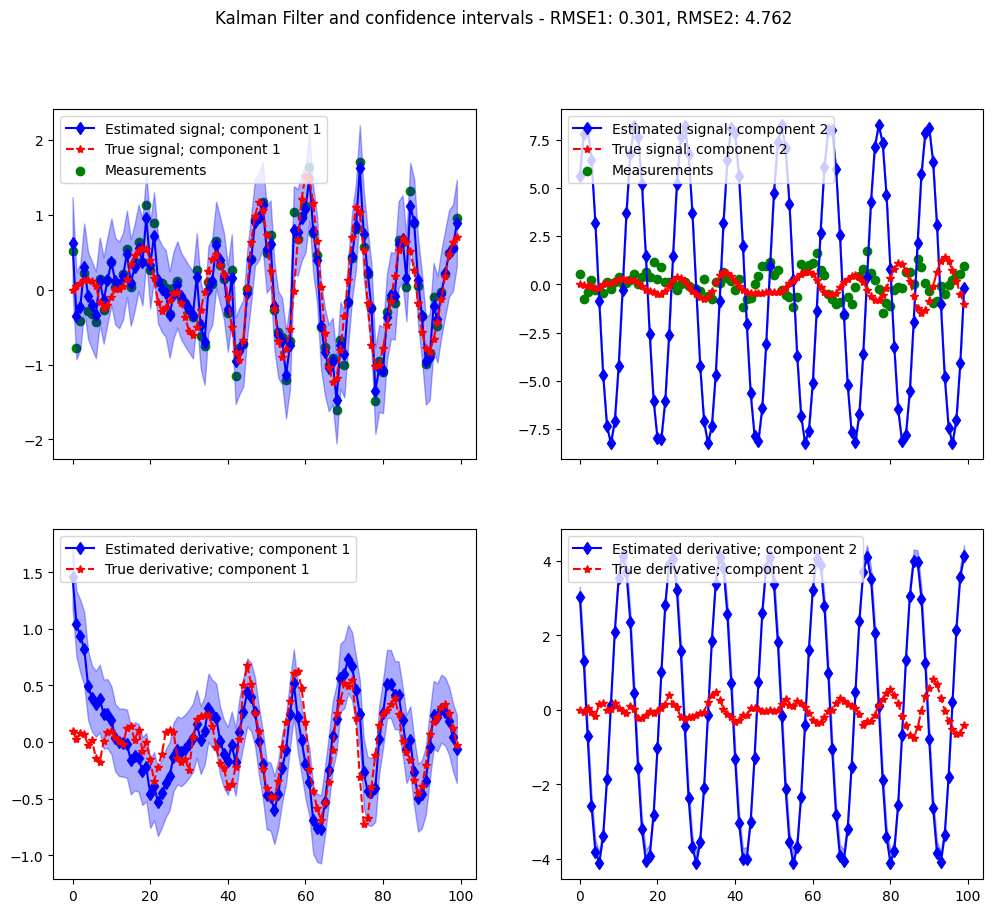

In [192]:
plot_results(kalman_states1, true_states, observations, "Kalman Filter", 2.0, kalman_covariances1)

### Plot the differences between the two different runs of the filter

In [193]:
mdf1 = kalman_states - kalman_states1
cdf1 = kalman_covariances - kalman_covariances1

Text(0.5, 0, 'iterations')

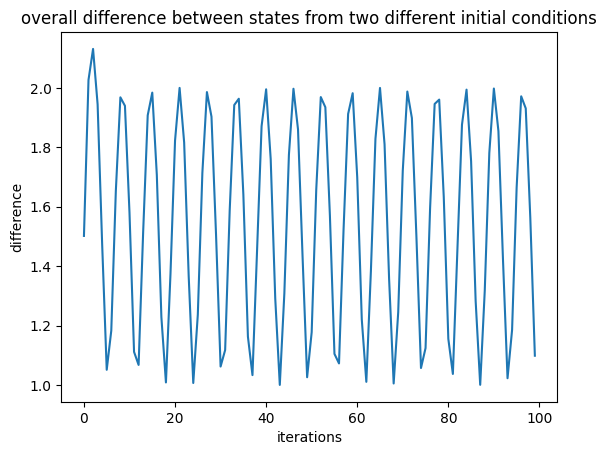

In [194]:
plt.plot(np.linalg.norm(mdf1, axis=1))
plt.title("overall difference between states from two different initial conditions")
plt.ylabel("difference")
plt.xlabel("iterations")

differences between the states after starting from two different initial conditions never approach each other, this strongly suggests an unstabilized system.

In [195]:
mdf_1= [np.linalg.norm(mdf1[ii,:][0:2]) for ii in range(100)]
mdf_2= [np.linalg.norm(mdf1[ii,:][2:4]) for ii in range(100)]

Text(0.5, 0, 'iterations')

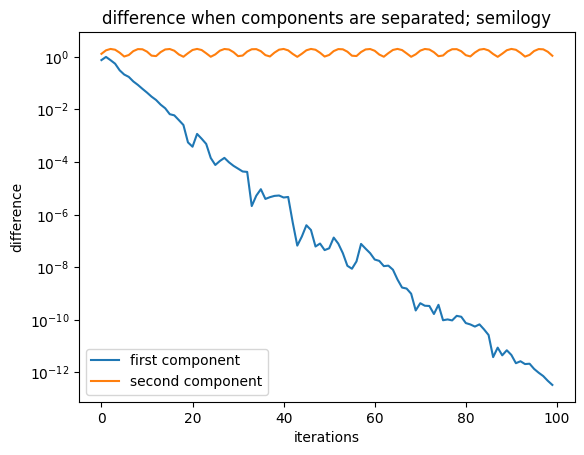

In [196]:
plt.semilogy(mdf_1, label="first component")
plt.semilogy(mdf_2, label="second component")
plt.legend()
plt.title("difference when components are separated; semilogy")
plt.ylabel("difference")
plt.xlabel("iterations")

We can see that component 1 stabilies but compenent 2 does not, which also suggests that the whole system is not stabilizing.

Observations of one will not give you information of the other since these oscillators are uncoupled, hence this "unstable" filtering. 

Possible ways to fix is to change the variables (H, A) to include more "cross-talk" between the models, i.e., some form of covariance. 
